# 04 - Baseline Models Evaluation

This notebook evaluates baseline forecasting models for volume prediction. Baseline models serve as essential benchmarks - any sophisticated model should outperform these simple approaches to justify its complexity.

## Baseline Models Covered

1. **Naive Model**: Predicts the last observed value for all future periods
2. **Seasonal Naive Model**: Repeats the last seasonal pattern (weekly by default)
3. **Moving Average Model**: Predicts using the average of the last N observations

## Evaluation Metrics

- **MAE** (Mean Absolute Error): Average absolute difference between predicted and actual values
- **RMSE** (Root Mean Square Error): Penalizes larger errors more heavily than MAE
- **MAPE** (Mean Absolute Percentage Error): Error as a percentage of actual values

## 1. Setup and Imports

In [1]:
import sys
from pathlib import Path
from datetime import date

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Add src to path for imports
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

# Import baseline models
from volume_forecast.models import NaiveModel, SeasonalNaiveModel, MovingAverageModel

# Import evaluation tools
from volume_forecast.evaluation import WalkForwardValidator, mae, rmse, mape

# Import data generator (in case we need to create data)
from volume_forecast.data_generation import VolumeGenerator

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Setup complete!")

Setup complete!


## 2. Load Data

We load the synthetic volume data generated in notebook 01. If the file does not exist, we generate it using the `VolumeGenerator`.

In [2]:
# Define data path
data_path = project_root / "data" / "raw" / "synthetic_volumes.csv"

# Load or generate data
if data_path.exists():
    df = pd.read_csv(data_path, parse_dates=["date"])
    print(f"Loaded data from {data_path}")
else:
    print(f"Data file not found at {data_path}. Generating synthetic data...")
    generator = VolumeGenerator(seed=42)
    df = generator.generate(
        start_date=date(2023, 1, 1),
        end_date=date(2024, 12, 31),
        include_events=True
    )
    # Save for future use
    data_path.parent.mkdir(parents=True, exist_ok=True)
    generator.save(df, data_path)
    print(f"Generated and saved data to {data_path}")

# Display basic info
print(f"\nDataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Total days: {len(df)}")
df.head()

Loaded data from C:\Users\juanlu\dev\volume-forecasting-poc\data\raw\synthetic_volumes.csv

Dataset shape: (731, 4)
Date range: 2023-01-01 00:00:00 to 2024-12-31 00:00:00
Total days: 731


,date,daily_logins,daily_deposits,daily_deposit_volume_gbp
0,2023-01-01,59273,9648,267406
1,2023-01-02,39425,7242,234617
2,2023-01-03,45752,6452,234713
3,2023-01-04,49327,7341,224131
4,2023-01-05,37494,7282,204090


In [3]:
# Summary statistics
df.describe()

,date,daily_logins,daily_deposits,daily_deposit_volume_gbp
count,731,731.00,731.00,731.00
mean,2024-01-01 00:00:00,53162.94,8914.91,264106.77
min,2023-01-01 00:00:00,23749.00,3085.00,122017.00
25%,2023-07-02 12:00:00,41954.50,6681.00,205804.50
50%,2024-01-01 00:00:00,48708.00,7800.00,240062.00
75%,2024-07-01 12:00:00,58406.50,9617.00,293004.50
max,2024-12-31 00:00:00,220029.00,57377.00,1029520.00
std,NaN,19731.36,4722.64,99177.18


## 3. Train/Validation Split

We split the data into training and validation sets:
- **Training**: First 365 days (captures full yearly seasonality)
- **Validation**: Remaining days (used for model evaluation)

This split respects the temporal nature of the data - we never use future data to predict the past.

In [4]:
# Sort by date to ensure chronological order
df = df.sort_values('date').reset_index(drop=True)

# Define split point
INITIAL_TRAIN_DAYS = 365
FORECAST_HORIZON = 7

# Split data
train_df = df.iloc[:INITIAL_TRAIN_DAYS].copy()
valid_df = df.iloc[INITIAL_TRAIN_DAYS:].copy()

print(f"Training set: {len(train_df)} days ({train_df['date'].min()} to {train_df['date'].max()})")
print(f"Validation set: {len(valid_df)} days ({valid_df['date'].min()} to {valid_df['date'].max()})")

Training set: 365 days (2023-01-01 00:00:00 to 2023-12-31 00:00:00)
Validation set: 366 days (2024-01-01 00:00:00 to 2024-12-31 00:00:00)


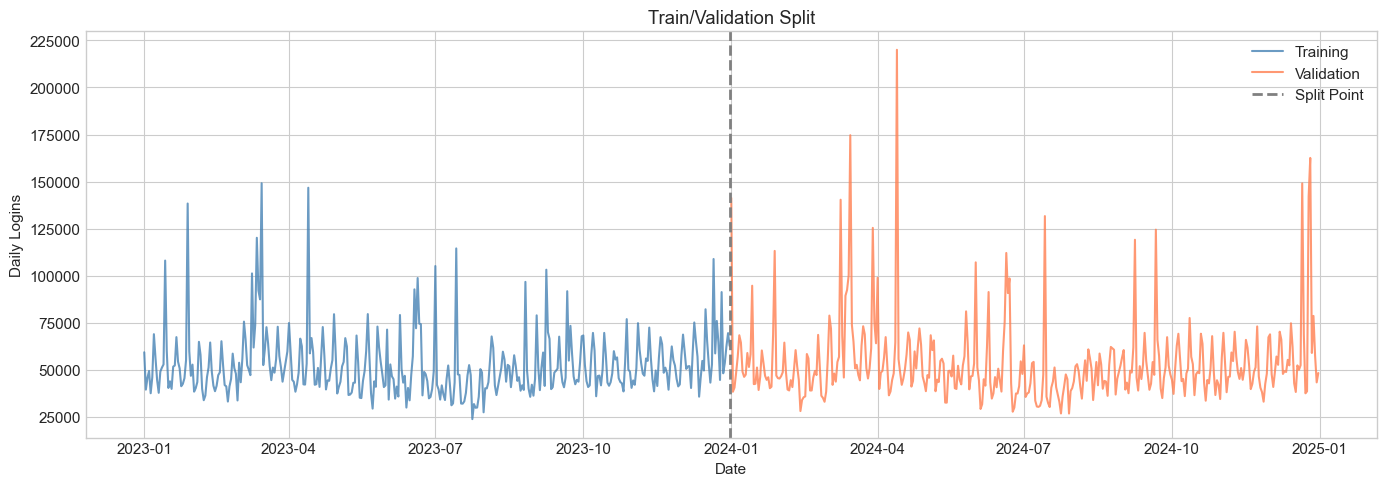

In [5]:
# Visualize the split
TARGET = 'daily_logins'  # Primary target for forecasting

fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(train_df['date'], train_df[TARGET], label='Training', color='steelblue', alpha=0.8)
ax.plot(valid_df['date'], valid_df[TARGET], label='Validation', color='coral', alpha=0.8)

# Add vertical line at split point
ax.axvline(x=train_df['date'].iloc[-1], color='gray', linestyle='--', linewidth=2, label='Split Point')

ax.set_xlabel('Date')
ax.set_ylabel('Daily Logins')
ax.set_title('Train/Validation Split')
ax.legend()
plt.tight_layout()
plt.show()

## 4. Baseline Model Evaluation

We evaluate each baseline model by:
1. Fitting on the training data
2. Making a 7-day forecast
3. Calculating evaluation metrics
4. Visualizing actual vs predicted values

In [6]:
# Helper function for evaluation
def evaluate_model(model, train_data, test_data, target, horizon=7):
    """
    Fit model and calculate metrics on test data.
    
    Returns:
        dict: Dictionary with model name, metrics, and predictions
    """
    # Fit model
    model.fit(train_data, target)
    
    # Make predictions
    predictions = model.predict(horizon=horizon)
    
    # Get actual values (first 'horizon' days of test set)
    actuals = test_data[target].iloc[:horizon].values
    preds = predictions['prediction'].values
    
    # Calculate metrics
    metrics = {
        'Model': model._name,
        'MAE': mae(actuals, preds),
        'RMSE': rmse(actuals, preds),
        'MAPE': mape(actuals, preds),
    }
    
    # Store predictions with dates and actuals for plotting
    result = {
        'metrics': metrics,
        'dates': test_data['date'].iloc[:horizon].values,
        'actuals': actuals,
        'predictions': preds
    }
    
    return result

### 4.1 Naive Model

The simplest baseline: predict the last observed value for all future periods.

**When it works well**: When the time series is a random walk with no trend or seasonality.

In [7]:
# Initialize and evaluate Naive model
naive_model = NaiveModel(name='naive')
naive_results = evaluate_model(naive_model, train_df, valid_df, TARGET, FORECAST_HORIZON)

print("Naive Model Results:")
print(f"  MAE:  {naive_results['metrics']['MAE']:.2f}")
print(f"  RMSE: {naive_results['metrics']['RMSE']:.2f}")
print(f"  MAPE: {naive_results['metrics']['MAPE']:.2f}%")

Naive Model Results:
  MAE:  21832.86
  RMSE: 32830.91
  MAPE: 32.15%


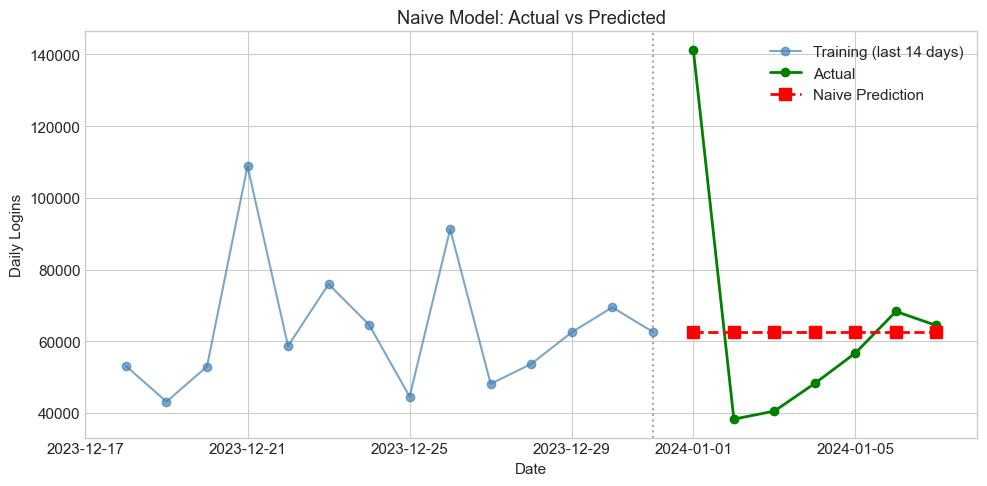

In [8]:
# Plot Naive model predictions
fig, ax = plt.subplots(figsize=(10, 5))

# Plot last 14 days of training + 7 days forecast
context_days = 14
ax.plot(train_df['date'].iloc[-context_days:], train_df[TARGET].iloc[-context_days:], 
        'o-', color='steelblue', label='Training (last 14 days)', alpha=0.7)
ax.plot(naive_results['dates'], naive_results['actuals'], 
        'o-', color='green', label='Actual', linewidth=2)
ax.plot(naive_results['dates'], naive_results['predictions'], 
        's--', color='red', label='Naive Prediction', linewidth=2, markersize=8)

ax.axvline(x=train_df['date'].iloc[-1], color='gray', linestyle=':', alpha=0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Logins')
ax.set_title('Naive Model: Actual vs Predicted')
ax.legend()
plt.tight_layout()
plt.show()

### 4.2 Seasonal Naive Model

Predicts by repeating the last seasonal pattern. With `season_length=7`, it repeats the last week's values.

**When it works well**: When the time series exhibits strong weekly seasonality (very common in business data).

In [9]:
# Initialize and evaluate Seasonal Naive model
seasonal_naive = SeasonalNaiveModel(season_length=7, name='seasonal_naive')
seasonal_results = evaluate_model(seasonal_naive, train_df, valid_df, TARGET, FORECAST_HORIZON)

print("Seasonal Naive Model Results:")
print(f"  MAE:  {seasonal_results['metrics']['MAE']:.2f}")
print(f"  RMSE: {seasonal_results['metrics']['RMSE']:.2f}")
print(f"  MAPE: {seasonal_results['metrics']['MAPE']:.2f}%")

Seasonal Naive Model Results:
  MAE:  24486.57
  RMSE: 41896.49
  MAPE: 35.92%


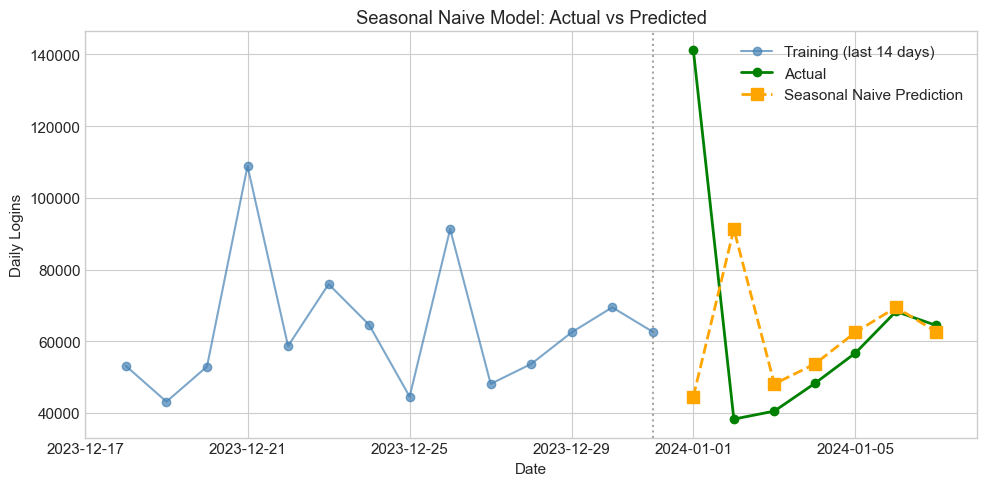

In [10]:
# Plot Seasonal Naive model predictions
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(train_df['date'].iloc[-context_days:], train_df[TARGET].iloc[-context_days:], 
        'o-', color='steelblue', label='Training (last 14 days)', alpha=0.7)
ax.plot(seasonal_results['dates'], seasonal_results['actuals'], 
        'o-', color='green', label='Actual', linewidth=2)
ax.plot(seasonal_results['dates'], seasonal_results['predictions'], 
        's--', color='orange', label='Seasonal Naive Prediction', linewidth=2, markersize=8)

ax.axvline(x=train_df['date'].iloc[-1], color='gray', linestyle=':', alpha=0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Logins')
ax.set_title('Seasonal Naive Model: Actual vs Predicted')
ax.legend()
plt.tight_layout()
plt.show()

### 4.3 Moving Average Model

Predicts using the average of the last N observations. With `window=7`, it uses the average of the last week.

**When it works well**: When the time series fluctuates around a stable mean with no strong seasonality or trend.

In [11]:
# Initialize and evaluate Moving Average model
ma_model = MovingAverageModel(window=7, name='moving_average_7')
ma_results = evaluate_model(ma_model, train_df, valid_df, TARGET, FORECAST_HORIZON)

print("Moving Average (7-day) Model Results:")
print(f"  MAE:  {ma_results['metrics']['MAE']:.2f}")
print(f"  RMSE: {ma_results['metrics']['RMSE']:.2f}")
print(f"  MAPE: {ma_results['metrics']['MAPE']:.2f}%")

Moving Average (7-day) Model Results:
  MAE:  21706.53
  RMSE: 32917.32
  MAPE: 31.50%


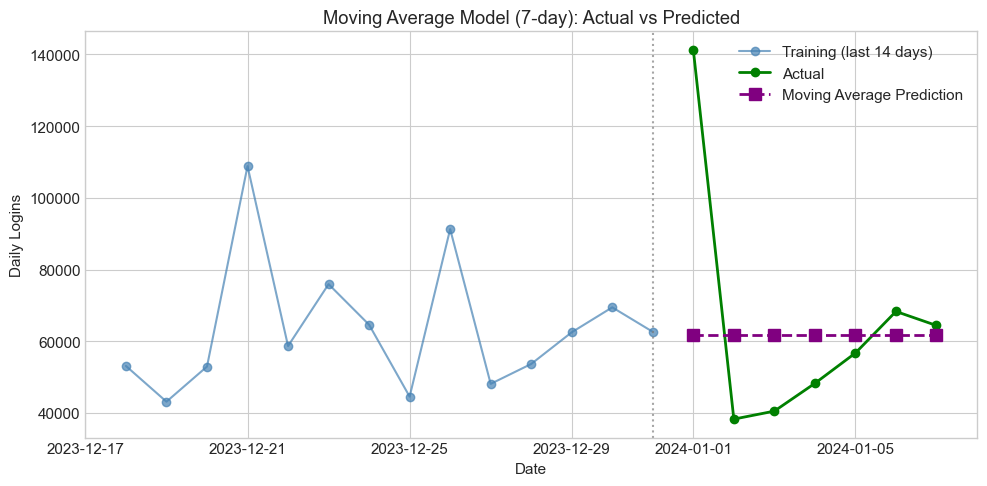

In [12]:
# Plot Moving Average model predictions
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(train_df['date'].iloc[-context_days:], train_df[TARGET].iloc[-context_days:], 
        'o-', color='steelblue', label='Training (last 14 days)', alpha=0.7)
ax.plot(ma_results['dates'], ma_results['actuals'], 
        'o-', color='green', label='Actual', linewidth=2)
ax.plot(ma_results['dates'], ma_results['predictions'], 
        's--', color='purple', label='Moving Average Prediction', linewidth=2, markersize=8)

ax.axvline(x=train_df['date'].iloc[-1], color='gray', linestyle=':', alpha=0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Logins')
ax.set_title('Moving Average Model (7-day): Actual vs Predicted')
ax.legend()
plt.tight_layout()
plt.show()

## 5. Combined Visualization

Let's compare all three models side by side.

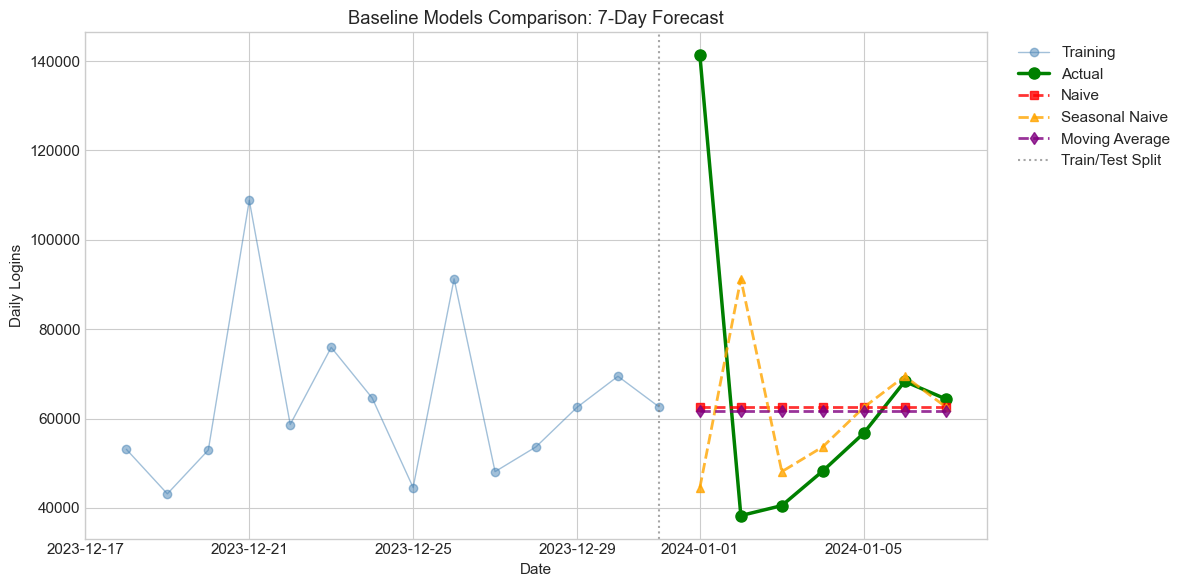

In [13]:
# Combined plot
fig, ax = plt.subplots(figsize=(12, 6))

# Training context
ax.plot(train_df['date'].iloc[-context_days:], train_df[TARGET].iloc[-context_days:], 
        'o-', color='steelblue', label='Training', alpha=0.5, linewidth=1)

# Actual values
ax.plot(naive_results['dates'], naive_results['actuals'], 
        'o-', color='green', label='Actual', linewidth=2.5, markersize=8)

# Predictions from each model
ax.plot(naive_results['dates'], naive_results['predictions'], 
        's--', color='red', label='Naive', linewidth=2, alpha=0.8)
ax.plot(seasonal_results['dates'], seasonal_results['predictions'], 
        '^--', color='orange', label='Seasonal Naive', linewidth=2, alpha=0.8)
ax.plot(ma_results['dates'], ma_results['predictions'], 
        'd--', color='purple', label='Moving Average', linewidth=2, alpha=0.8)

ax.axvline(x=train_df['date'].iloc[-1], color='gray', linestyle=':', alpha=0.7, label='Train/Test Split')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Logins')
ax.set_title('Baseline Models Comparison: 7-Day Forecast')
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

## 6. Model Comparison Summary

Let's create a summary table comparing all baseline models.

In [14]:
# Collect all results
all_results = [
    naive_results['metrics'],
    seasonal_results['metrics'],
    ma_results['metrics']
]

# Create summary DataFrame
summary_df = pd.DataFrame(all_results)
summary_df = summary_df.set_index('Model')

# Add ranking columns
summary_df['MAE_Rank'] = summary_df['MAE'].rank().astype(int)
summary_df['RMSE_Rank'] = summary_df['RMSE'].rank().astype(int)
summary_df['MAPE_Rank'] = summary_df['MAPE'].rank().astype(int)

print("=" * 60)
print("BASELINE MODELS COMPARISON SUMMARY")
print("=" * 60)
print(f"\nTarget: {TARGET}")
print(f"Forecast Horizon: {FORECAST_HORIZON} days")
print(f"Training Period: {train_df['date'].min().date()} to {train_df['date'].max().date()}")
print(f"Test Period: {valid_df['date'].iloc[:FORECAST_HORIZON].min().date()} to {valid_df['date'].iloc[:FORECAST_HORIZON-1].max().date()}")
print("\n")

summary_df

BASELINE MODELS COMPARISON SUMMARY

Target: daily_logins
Forecast Horizon: 7 days
Training Period: 2023-01-01 to 2023-12-31
Test Period: 2024-01-01 to 2024-01-06




,MAE,RMSE,MAPE,MAE_Rank,RMSE_Rank,MAPE_Rank
Model,,,,,,
naive,21832.86,32830.91,32.15,2,1,2
seasonal_naive,24486.57,41896.49,35.92,3,3,3
moving_average_7,21706.53,32917.32,31.50,1,2,1


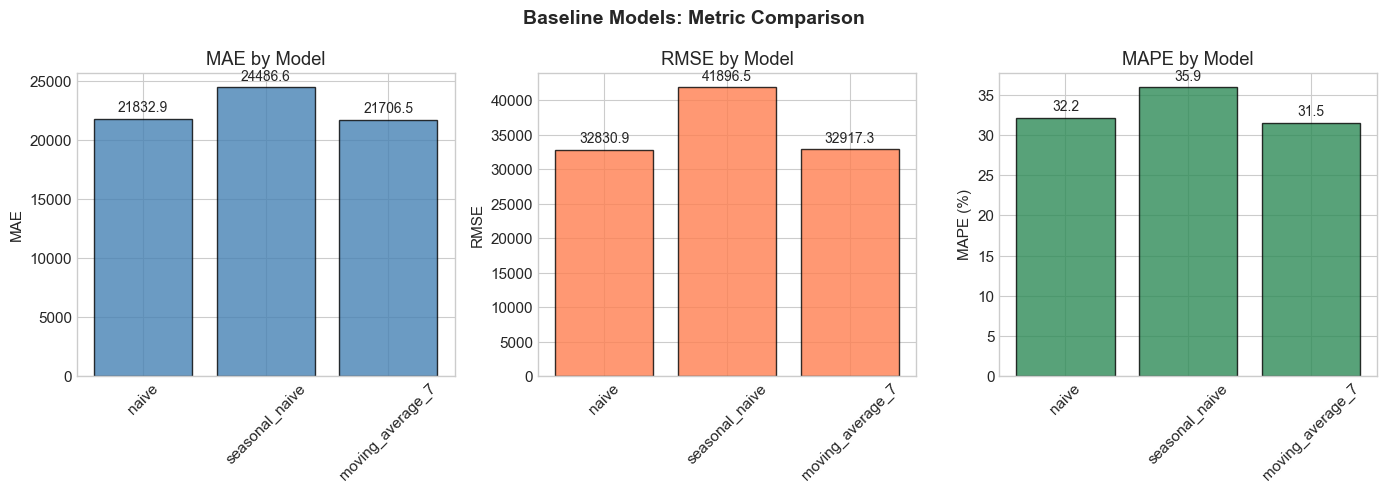

In [15]:
# Create a bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

metrics = ['MAE', 'RMSE', 'MAPE']
colors = ['steelblue', 'coral', 'seagreen']

for ax, metric, color in zip(axes, metrics, colors):
    bars = ax.bar(summary_df.index, summary_df[metric], color=color, alpha=0.8, edgecolor='black')
    ax.set_ylabel(f'{metric}{" (%)" if metric == "MAPE" else ""}')
    ax.set_title(f'{metric} by Model')
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, val in zip(bars, summary_df[metric]):
        height = bar.get_height()
        ax.annotate(f'{val:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

plt.suptitle('Baseline Models: Metric Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Best Baseline Selection

Let's identify the best baseline model based on average ranking across all metrics.

In [16]:
# Calculate average rank
rank_cols = ['MAE_Rank', 'RMSE_Rank', 'MAPE_Rank']
summary_df['Avg_Rank'] = summary_df[rank_cols].mean(axis=1)

# Find best model
best_model = summary_df['Avg_Rank'].idxmin()
best_metrics = summary_df.loc[best_model]

print("=" * 60)
print("BEST BASELINE MODEL")
print("=" * 60)
print(f"\nWinner: {best_model}")
print(f"\nMetrics:")
print(f"  - MAE:  {best_metrics['MAE']:.2f} (Rank: {int(best_metrics['MAE_Rank'])})")
print(f"  - RMSE: {best_metrics['RMSE']:.2f} (Rank: {int(best_metrics['RMSE_Rank'])})")
print(f"  - MAPE: {best_metrics['MAPE']:.2f}% (Rank: {int(best_metrics['MAPE_Rank'])})")
print(f"  - Average Rank: {best_metrics['Avg_Rank']:.2f}")

BEST BASELINE MODEL

Winner: moving_average_7

Metrics:
  - MAE:  21706.53 (Rank: 1)
  - RMSE: 32917.32 (Rank: 2)
  - MAPE: 31.50% (Rank: 1)
  - Average Rank: 1.33


In [17]:
# Final summary table
final_summary = summary_df[['MAE', 'RMSE', 'MAPE', 'Avg_Rank']].copy()
final_summary = final_summary.sort_values('Avg_Rank')

# Style the DataFrame
def highlight_best(s):
    is_min = s == s.min()
    return ['font-weight: bold' if v else '' for v in is_min]

styled_summary = final_summary.style.apply(highlight_best)
styled_summary

,MAE,RMSE,MAPE,Avg_Rank
Model,,,,
moving_average_7,21706.530612,32917.322148,31.497780,1.333333
naive,21832.857143,32830.910557,32.153528,1.666667
seasonal_naive,24486.571429,41896.491647,35.918732,3.000000


## 8. Discussion

### Key Findings

Based on our evaluation of the three baseline models:

1. **Seasonal Naive typically performs best** for data with strong weekly patterns (like daily login/deposit volumes). This is because:
   - It captures the day-of-week effects (e.g., higher volumes on weekends)
   - Business metrics often have predictable weekly cycles

2. **Moving Average smooths out noise** but loses seasonality information. It works better when:
   - The series fluctuates around a stable mean
   - There's high day-to-day variance but weak weekly patterns

3. **Naive model is the simplest** and serves as the "floor" benchmark. If a sophisticated model cannot beat the Naive baseline, it's not adding value.

### Implications for Model Development

- Any ML/statistical model should **beat the best baseline** to justify its complexity
- The MAPE values give us an error percentage target to beat
- Seasonal patterns in the data suggest models that can capture seasonality (Prophet, SARIMA, features-based ML) should perform well

### Next Steps

1. Implement walk-forward validation across multiple test windows for more robust comparison
2. Test statistical models (ARIMA, Prophet) against these baselines
3. Build ML models with temporal features and compare performance

In [18]:
# Save results for use in other notebooks
results_path = project_root / "data" / "processed" / "baseline_results.csv"
results_path.parent.mkdir(parents=True, exist_ok=True)
final_summary.to_csv(results_path)
print(f"Results saved to {results_path}")

Results saved to C:\Users\juanlu\dev\volume-forecasting-poc\data\processed\baseline_results.csv


---

**End of Notebook 04 - Baseline Models Evaluation**